# Bayesian Marketing Mix Model
https://www.getcensus.com/blog/you-should-know-introduction-to-marketing-mix-modeling

- To get a better understanding of the relationships between your marketing channels and your target metric (i.e. conversions).
- To distinguish high ROI marketing channels from low ones and ultimately better optimize your marketing budget.
- To predict future conversions based on given input

In [48]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "/Applications/Diego Alejandro/2024_1/HP/"
os.chdir(path)

# Data Reading

In [3]:
data = pd.read_excel('DMR_case_study_data.xlsx')

In [4]:
# number of missing values per column
data.isnull().sum()

Date                   0
ProductID              0
UnitSales              0
AvgSellingPrice        0
SearchImpressions      0
SearchClicks           0
DisplayImpressions    14
DisplayClicks          0
RadioSpots             0
DailySiteVisits        0
PagesperVisit          0
BounceRate             0
dtype: int64

Since all the Nan values are in the variable column DisplayImpressions, meaning that the 'Total <font color='red'>paid</font> search impressions delivered daily' was not registered, a simple naive approach this time with not much context will be putting 0 as the total paid. 

In [5]:
data.fillna(0,inplace=True)

In [6]:
data.isnull().sum()

Date                  0
ProductID             0
UnitSales             0
AvgSellingPrice       0
SearchImpressions     0
SearchClicks          0
DisplayImpressions    0
DisplayClicks         0
RadioSpots            0
DailySiteVisits       0
PagesperVisit         0
BounceRate            0
dtype: int64

In [7]:
data.shape

(7013, 12)

# Identification

- Unit Sales := 'Total daily product sales for each Product ID'

- Average Sales Price := 'Average selling price for the units sold'

# Media Channels' impressions (spending)

- Search Impressions := 'Total <font color='red'>paid</font> search impressions delivered daily'

- Search Clicks := 'Total <font color='red'>paid</font> search clicks delivered daily'

- Display Impressions := 'Total <font color='red'>paid</font> display impressions delivered daily'

- Display Clicks := 'Total <font color='red'>paid</font> display clicks delivered daily'

# Control Variables

- Radio Spots := 'Total campaign radio ad spots daily'

- Daily site visits := 'Total visits to the website'

- Pages per visit := 'Average pages viewed per visit'

- Bounce rate := 'Rate at which consumers left the website after a single page view'

to fit a Bayesian regression model IN ORDER TO <font color='blue'>predict sales.</font>

understanding of category variables:
https://www.latentview.com/wp-content/uploads/2019/08/Marketing-Mix-Model.pdf

# Data preparing

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [10]:
spark = SparkSession \
    .builder \
    .appName("HP_Marketing") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [11]:
sparkDF=spark.createDataFrame(data) # From pandas df to pyspark df

In [12]:
sparkDF.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- ProductID: string (nullable = true)
 |-- UnitSales: long (nullable = true)
 |-- AvgSellingPrice: double (nullable = true)
 |-- SearchImpressions: long (nullable = true)
 |-- SearchClicks: long (nullable = true)
 |-- DisplayImpressions: double (nullable = true)
 |-- DisplayClicks: long (nullable = true)
 |-- RadioSpots: double (nullable = true)
 |-- DailySiteVisits: double (nullable = true)
 |-- PagesperVisit: double (nullable = true)
 |-- BounceRate: double (nullable = true)



In [13]:
sparkDF.show(3)

+-------------------+---------+---------+----------------+-----------------+------------+------------------+-------------+----------+---------------+----------------+-----------------+
|               Date|ProductID|UnitSales| AvgSellingPrice|SearchImpressions|SearchClicks|DisplayImpressions|DisplayClicks|RadioSpots|DailySiteVisits|   PagesperVisit|       BounceRate|
+-------------------+---------+---------+----------------+-----------------+------------+------------------+-------------+----------+---------------+----------------+-----------------+
|2019-08-02 00:00:00|      300|      230|26.9058493081626|             3906|          67|              10.0|            0|       0.0|1139441.9118279|4.50002009141716|0.475408706149982|
|2019-08-02 00:00:00|      301|     1712|22.7849234042638|            16420|         495|              10.0|            0|       0.0|1139441.9118279|4.50002009141716|0.475408706149982|
|2019-08-02 00:00:00|      302|     1442| 20.954666909623|            14598

In [14]:
sparkDF.createOrReplaceTempView("data_")
# this is gonna be the name of the table inside the SQL syntax for a query

# Summaryzing data for all the products

A model taking into account all the products and variables would be the final task. However in order to begin understanding the variables and model for marketing strategies I will chose just one product and analyze its dataset.

In [16]:
q = "SELECT SUBSTRING(Date, 1, 10) AS Date, "\
    "ROUND(SUM(UnitSales * AvgSellingPrice),2) AS Sales_, "\
    "ROUND((SUM(SearchImpressions * UnitSales) / SUM(UnitSales)),2) AS SearI, "\
    "ROUND(AVG(SearchClicks),2) AS SearC, "\
    "ROUND(AVG(DisplayImpressions),2) AS DispI, "\
    "ROUND(AVG(DisplayClicks),2) AS DispC, "\
    "ROUND(AVG(RadioSpots),2) AS Radio, "\
    "ROUND(AVG(DailySiteVisits),2) AS DailySV, "\
    "ROUND(AVG(PagesperVisit),2) AS PagespV, "\
    "ROUND(AVG(BounceRate),2) AS BounceR "\
    "FROM data_ "\
    "GROUP BY Date ORDER BY Date ASC;"

In [17]:
out_join = spark.sql(q)

In [18]:
out_join.show(35)

+----------+---------+---------+------+---------+------+-----+----------+-------+-------+
|      Date|   Sales_|    SearI| SearC|    DispI| DispC|Radio|   DailySV|PagespV|BounceR|
+----------+---------+---------+------+---------+------+-----+----------+-------+-------+
|2019-08-02|518780.35| 56003.91|153.63|     10.0|   0.0|  0.0|1139441.91|    4.5|   0.48|
|2019-08-03|343452.93| 52063.35|125.19|     15.0|   0.0|  0.0|1178689.64|    4.0|   0.51|
|2019-08-04| 427414.8| 56948.52|155.73|     13.0|   0.0|  0.0|1217203.92|   3.93|   0.51|
|2019-08-05|676967.76| 62110.57|161.35|     16.0|   0.0|  0.0| 1263040.5|   4.88|   0.49|
|2019-08-06|715485.43| 74106.85|182.26|     10.0|   0.0|  0.0|1316645.09|   4.59|    0.5|
|2019-08-07|652132.01| 82741.73|160.84|     10.0|   0.0|  0.0|1222540.63|   4.35|   0.52|
|2019-08-08|594223.02| 63017.76|147.79|1005270.0| 349.0|  0.0|1224173.51|   4.37|   0.52|
|2019-08-09|551629.51| 65246.27|154.06|1010793.0| 377.0|  0.0|1314142.91|   4.41|    0.5|
|2019-08-1

In [19]:
n = out_join.count()
print(f'Number of observations: {n} days')

Number of observations: 364 days


In [20]:
out_join.createOrReplaceTempView("data_cleaned")
# in case we need to query inside this new table, the name for SQL syntax query will be data_cleaned

In [21]:
df_main = out_join.toPandas()

In [22]:
df_main.head()

,Date,Sales_,SearI,SearC,DispI,DispC,Radio,DailySV,PagespV,BounceR
0,2019-08-02,518780.35,56003.91,153.63,10.0,0.0,0.0,1139441.91,4.50,0.48
1,2019-08-03,343452.93,52063.35,125.19,15.0,0.0,0.0,1178689.64,4.00,0.51
2,2019-08-04,427414.80,56948.52,155.73,13.0,0.0,0.0,1217203.92,3.93,0.51
3,2019-08-05,676967.76,62110.57,161.35,16.0,0.0,0.0,1263040.50,4.88,0.49
4,2019-08-06,715485.43,74106.85,182.26,10.0,0.0,0.0,1316645.09,4.59,0.50


With this df_main data set carry out the whole analysis.

# Data for product id - 300

In [23]:
q1 = "SELECT SUBSTRING(Date, 1, 10) AS Date, "\
     "ROUND(UnitSales,2) AS sales, "\
     "ROUND(AvgSellingPrice,2) AS AvgSP, "\
     "ROUND(SearchImpressions,2) AS SearImp, "\
     "ROUND(SearchClicks,2) AS SearCli, "\
     "ROUND(DisplayImpressions,2) AS DispImp, "\
     "ROUND(DisplayClicks,2) AS DispCli, "\
     "ROUND(RadioSpots,2) AS Radio, "\
     "ROUND(DailySiteVisits,2) AS DailySV, "\
     "ROUND(PagesperVisit,2) AS Pages_pv, "\
     "ROUND(BounceRate,2) AS BounceR "\
     "FROM data_ WHERE ProductId = 300;"
p_300 = spark.sql(q1)

In [24]:
p_300.show(3)

+----------+-----+-----+-------+-------+-------+-------+-----+----------+--------+-------+
|      Date|sales|AvgSP|SearImp|SearCli|DispImp|DispCli|Radio|   DailySV|Pages_pv|BounceR|
+----------+-----+-----+-------+-------+-------+-------+-----+----------+--------+-------+
|2019-08-02|  230|26.91|   3906|     67|   10.0|      0|  0.0|1139441.91|     4.5|   0.48|
|2019-08-03|  176|25.76|   3611|     46|   15.0|      0|  0.0|1178689.64|     4.0|   0.51|
|2019-08-04|  208|26.23|   4700|     67|   13.0|      0|  0.0|1217203.92|    3.93|   0.51|
+----------+-----+-----+-------+-------+-------+-------+-----+----------+--------+-------+
only showing top 3 rows



In [25]:
p_300.count()

344

In [26]:
df_p300 = p_300.toPandas()
df_p300.head(5)

,Date,sales,AvgSP,SearImp,SearCli,DispImp,DispCli,Radio,DailySV,Pages_pv,BounceR
0,2019-08-02,230,26.91,3906,67,10.0,0,0.0,1139441.91,4.50,0.48
1,2019-08-03,176,25.76,3611,46,15.0,0,0.0,1178689.64,4.00,0.51
2,2019-08-04,208,26.23,4700,67,13.0,0,0.0,1217203.92,3.93,0.51
3,2019-08-05,186,27.05,5015,66,16.0,0,0.0,1263040.50,4.88,0.49
4,2019-08-06,272,26.42,4882,93,10.0,0,0.0,1316645.09,4.59,0.50


In [27]:
df_p300.dtypes

Date         object
sales         int64
AvgSP       float64
SearImp       int64
SearCli       int64
DispImp     float64
DispCli       int64
Radio       float64
DailySV     float64
Pages_pv    float64
BounceR     float64
dtype: object

# Exploratory Data Analysis

In [28]:
# dates = df_p300['Date']
SerieSales = pd.Series(df_p300['sales'].values,df_p300['Date'])

In [29]:
SerieSales

Date
2019-08-02    230
2019-08-03    176
2019-08-04    208
2019-08-05    186
2019-08-06    272
             ... 
2020-07-27    280
2020-07-28    200
2020-07-29    248
2020-07-30    188
2020-07-31    156
Length: 344, dtype: int64

Text(0.5, 0, 'Time')

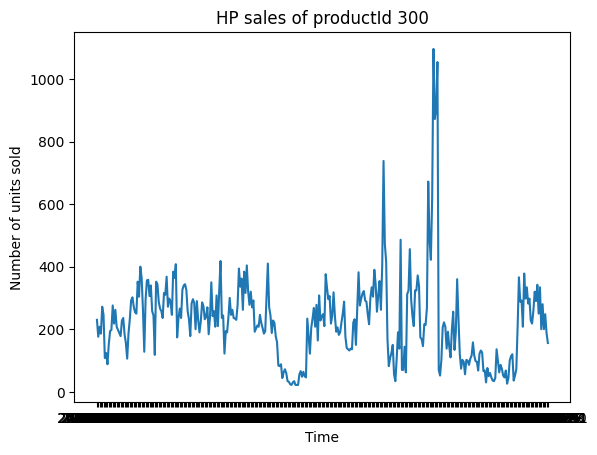

In [32]:
plt.plot(SerieSales)
plt.title("HP sales of productId 300")
plt.ylabel("Number of units sold")
plt.xlabel("Time")

we can see from the plot that:
- the time series has an increasing and decreasing trend over the time.
- it seems that it has no period that repeats, it could be because the data is shown dailly. Maybe plotting it monthly could should different insights.

If the data display (plot) characteristics suggesting nonstationarity (e.g., trend and seasonality), then it may be necessary to make a transformation so as to produce a new series that is more compatible with the assumption of $ \textbf{Stationarity}$. Page 164 [1]

$ \textbf{Stationarity}$

$\{X_t\}$ is (weakly) stationary if
- (i) $\mu_X(t)$ is independent of t, and
- (ii) $\gamma_X(t+h,t)$ is independent of t for each h.

Let's continue with more examinations of the dataset

In [34]:
corr_ = df_p300.corr()

<AxesSubplot:>

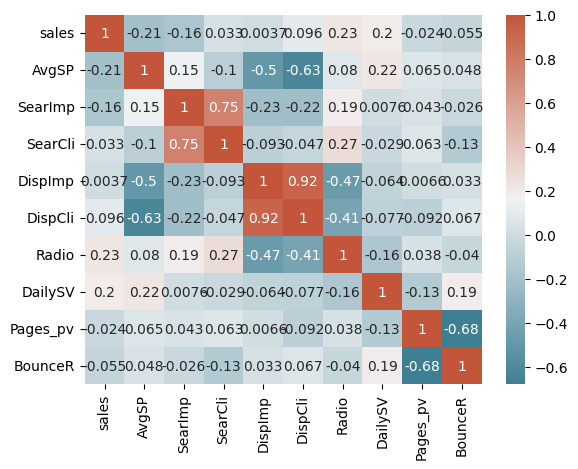

In [35]:
sns.heatmap(corr_, xticklabels = corr_.columns, yticklabels = corr_.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

- Radio and Daily site visits slightly correlate positively with Sales.

- Average Sale Price and Search impressions slightly correlate negatively with Sales.

&ensp;

- Search Click and Search Impressions highly correlate with each other.
- Display Click and Display Impressions highly correlate with each other.
- Pages per visit and Bounce Rate higly correlate negatively with each other.
- Average sale price and Display click higly correlate negatively with each other.

In order to avoid multicolinearity, one of them should be chosen. Let's say,

## Media Channels' impressions (spending)
- Search Impressions
- Display Impressions

## Control Variables
- Pages per visit
- Average sale price
- Radio
- Daily site visits

Even though passing through it the whole data set would lead to problems with multicolinearity, I pass the whole data set to see how the feature importance orders the variables according to sales.

# Model 3

# Feature importance

Feature importance allows you to determine how (you guessed it) “important” each input variable in predicting the output variable.

In [36]:
df_p300.head(3)

,Date,sales,AvgSP,SearImp,SearCli,DispImp,DispCli,Radio,DailySV,Pages_pv,BounceR
0,2019-08-02,230,26.91,3906,67,10.0,0,0.0,1139441.91,4.50,0.48
1,2019-08-03,176,25.76,3611,46,15.0,0,0.0,1178689.64,4.00,0.51
2,2019-08-04,208,26.23,4700,67,13.0,0,0.0,1217203.92,3.93,0.51


### Setting X and y variables

In [37]:
X = df_p300.iloc[:,2:12]
y = df_p300['sales']

# Building Random Forest model

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [40]:
model = RandomForestRegressor(random_state=1)

In [41]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [42]:
pred = model.predict(X_test)

The code above first creates a random forest model with sales as the target variable and the marketing channels as the feature inputs. Once we create the model, we then calculate the feature importance of each predictor and plot it on a bar chart.

# Visualizing Feature Importance

In [43]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

<AxesSubplot:>

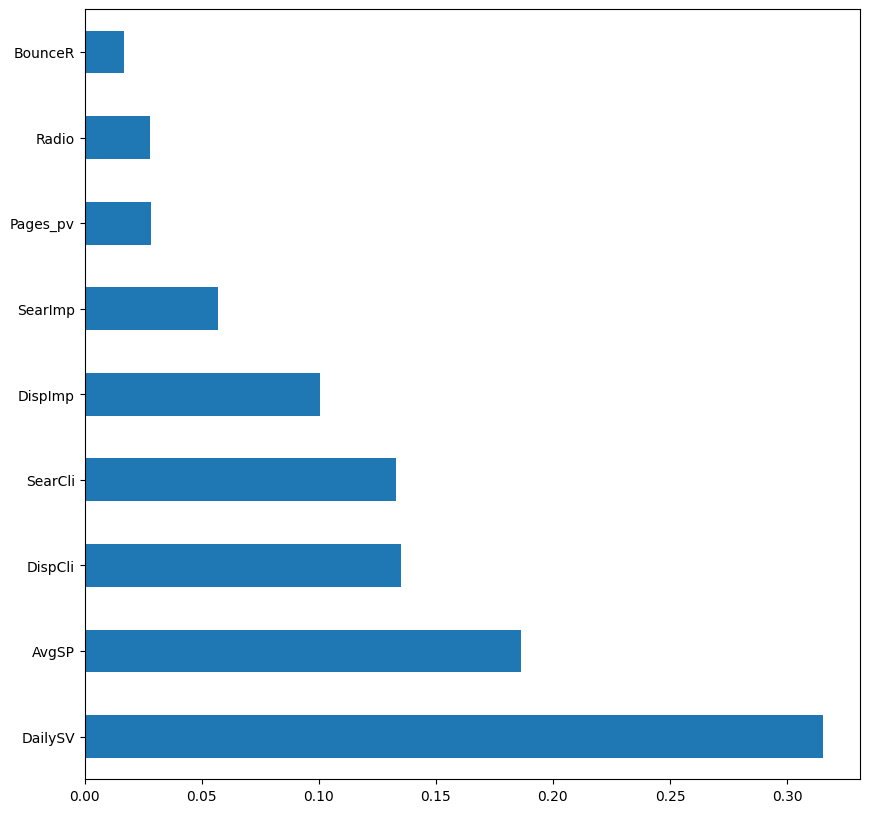

In [44]:
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

# Build the marketing mix model

In [45]:
import statsmodels.formula.api as sm

In [46]:
model = sm.ols(formula="sales ~ DailySV + AvgSP + SearCli + DispCli + SearImp + DispImp + Pages_pv + Radio + BounceR", data=df_p300).fit()

In [47]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     12.98
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           9.07e-18
Time:                        08:29:14   Log-Likelihood:                -2133.4
No. Observations:                 344   AIC:                             4287.
Df Residuals:                     334   BIC:                             4325.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    265.8066    318.495      0.835      0.4

Notice that the model is already complaining about multicolinearity!
Let's continue and see what variables we could include latter and get the model more parsimonious and if this helps in the end or not.

# Interpretation

With confidence level of $\alpha = 0.01$ we have that 
- the following parameters' coefficients are not significant:
    - AvgSP     - p-value$ = 0.024 > 0.01 = \alpha$
    - SearchCli - p-value$ = 0.095 > 0.01 = \alpha$
    - DispImp   - p-value$ = 0.018 > 0.01 = \alpha$
    - Pages_pv  - p-value$ = 0.686 > 0.01 = \alpha$
    - BounceR   - p-value$ = 0.060 > 0.01 = \alpha$

So we proceed to remove them from the model and see that the model's parameters are significant.

$\beta_1$ := 'By the increment of one <font color='blue'> visit to the website </font> sales of productId 300 will increace sales by 0.0004 on average'.

$\beta_2$ := 'By the increment of one dollar to <font color='purple'> average sales price</font> the  of productId 300 will decrease sales by 2.2201 on average'.

$\beta_3$ := 'By the increment of a dollar to the <font color='blue'> Total paid search clicks delivered Daily</font> of productId 300 will increace sales by 0.2788 on average'.

$\beta_4$ := 'By the increment of a dollar to <font color='blue'> Total paid display clicks delivered Daily</font> of productId 300 will increace sales by 0.0767 on average'.


- By the Jarque-Bera test, with a $p-value \approx 0.000 < 0.05 = \alpha$ there is enough evidence to reject $H_0$ that the data follows a normal distribution.

# Plot actual vs predicted values

In [49]:
y_pred = model.predict()

In [50]:
labels = df_p300['sales']
df_temp = pd.DataFrame({'Actual': labels, 'Predicted':y_pred})

In [51]:
df_temp.head()

,Actual,Predicted
0,230,208.151067
1,176,199.346013
2,208,213.226457
3,186,238.861126
4,272,262.970447


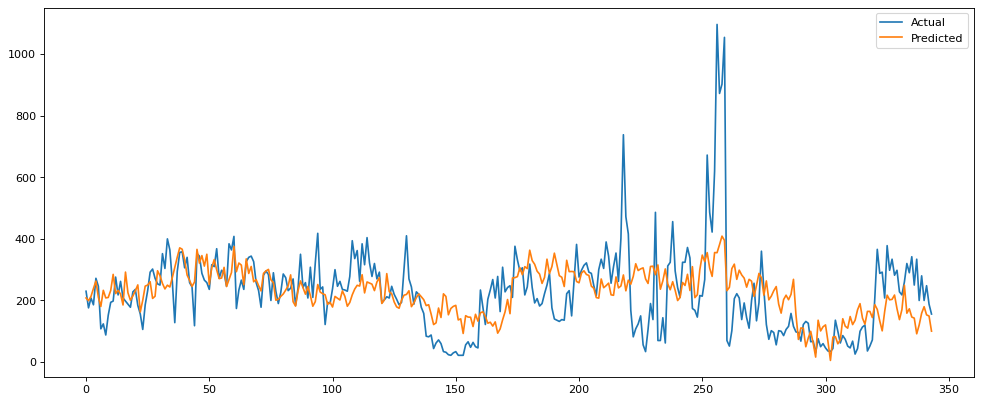

In [52]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
y1 = df_temp['Actual']
y2 = df_temp['Predicted']
plt.plot(y1, label = 'Actual')
plt.plot(y2, label = 'Predicted')
plt.legend()
plt.show()

In [53]:
def mse(y1,y2):
    return ((y2-y1)**2).sum()

In [54]:
mse(y1,y2)

4907853.885085573

### More models

In [55]:
model0 = sm.ols(formula="sales ~ DispImp + SearImp + Radio + AvgSP + Pages_pv + DailySV", data=df_p300).fit()

In [56]:
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     16.40
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           1.38e-16
Time:                        08:42:40   Log-Likelihood:                -2140.9
No. Observations:                 344   AIC:                             4296.
Df Residuals:                     337   BIC:                             4323.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -199.8017    105.132     -1.900      0.0

Still showing multicollinearity problems!!!

- DispImp not significant
- Pages_pv not significant

In [57]:
y_pred0 = model0.predict()
labels = df_p300['sales']
df_temp0 = pd.DataFrame({'Actual': labels, 'Predicted':y_pred0})

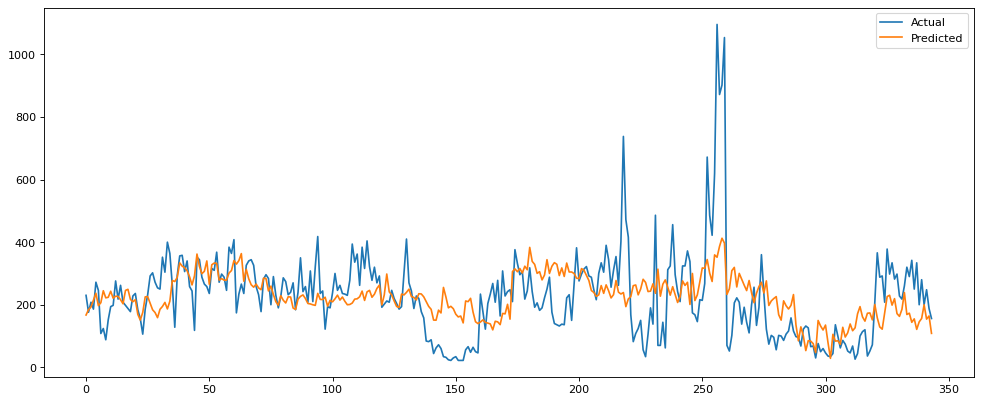

In [58]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
y1_0 = df_temp0['Actual']
y2_0 = df_temp0['Predicted']
plt.plot(y1_0, label = 'Actual')
plt.plot(y2_0, label = 'Predicted')
plt.legend()
plt.show()

In [59]:
mse(y1_0,y2_0)

5127134.272889225

24/02/22 18:05:17 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 686757 ms exceeds timeout 120000 ms
24/02/22 18:05:18 WARN SparkContext: Killing executors is not supported by current scheduler.
24/02/22 18:05:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

24/02/22 18:29:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 18:34:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 18:35:16 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 18:55:32 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 19:01:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

	at org.apache.spark.rpc.netty.NettyRpcCallContext.reply(NettyRpcCallContext.scala:32)
	at org.apache.spark.rpc.netty.RpcEndpointVerifier$$anonfun$receiveAndReply$1.applyOrElse(RpcEndpointVerifier.scala:31)
	... 8 more
24/02/22 19:02:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockM

24/02/22 19:04:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 19:30:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 19:55:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 20:31:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 20:32:01 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 20:32:10 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 20:49:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 20:51:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 21:32:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 22:05:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 22:33:40 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 23:34:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/23 00:35:55 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/23 01:36:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/23 02:18:22 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

### another one

In [83]:
model1 = sm.ols(formula="sales ~ DailySV + DispCli + SearImp + Radio", data=df_p300).fit()

In [84]:
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     21.21
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           1.30e-15
Time:                        14:42:39   Log-Likelihood:                -2134.9
No. Observations:                 342   AIC:                             4280.
Df Residuals:                     337   BIC:                             4299.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -248.5995     82.048     -3.030      0.0

Notice that here all the parameters are significant

In [85]:
y_pred1 = model1.predict()
labels = df_p300['sales']
df_temp1 = pd.DataFrame({'Actual': labels, 'Predicted':y_pred1})

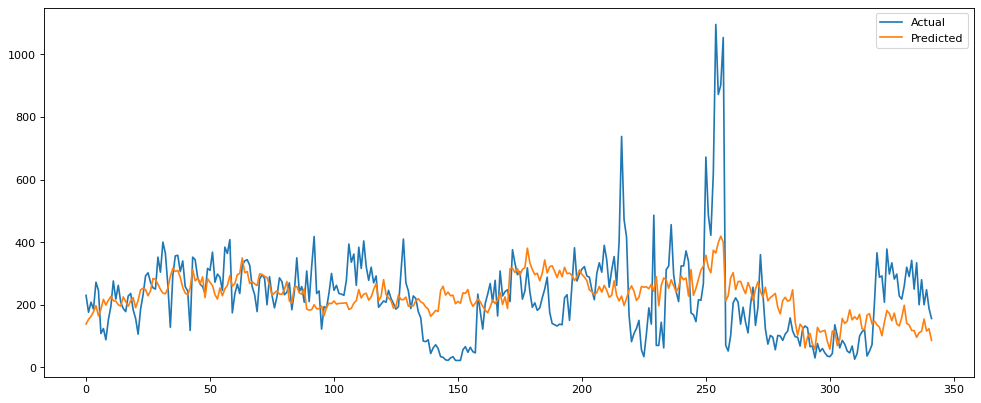

In [86]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
y1_1 = df_temp1['Actual']
y2_1 = df_temp1['Predicted']
plt.plot(y1_1, label = 'Actual')
plt.plot(y2_1, label = 'Predicted')
plt.legend()
plt.show()

In [99]:
mse(y1_1,y2_1)

5290804.508077819

In [88]:
model2 = sm.ols(formula="sales ~ DailySV + AvgSP + SearCli + DispCli", data=df_p300).fit()

In [89]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     10.53
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           4.76e-08
Time:                        14:46:25   Log-Likelihood:                -2153.1
No. Observations:                 342   AIC:                             4316.
Df Residuals:                     337   BIC:                             4335.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.4233     84.670     -0.655      0.5

In [93]:
model2 = sm.ols(formula="sales ~ DailySV + AvgSP", data=df_p300).fit()

In [94]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     20.23
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           5.03e-09
Time:                        14:48:01   Log-Likelihood:                -2154.0
No. Observations:                 342   AIC:                             4314.
Df Residuals:                     339   BIC:                             4325.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.7909     81.666     -0.940      0.3

In [95]:
y_pred2 = model2.predict()
labels = df_p300['sales']
df_temp2 = pd.DataFrame({'Actual': labels, 'Predicted':y_pred2})

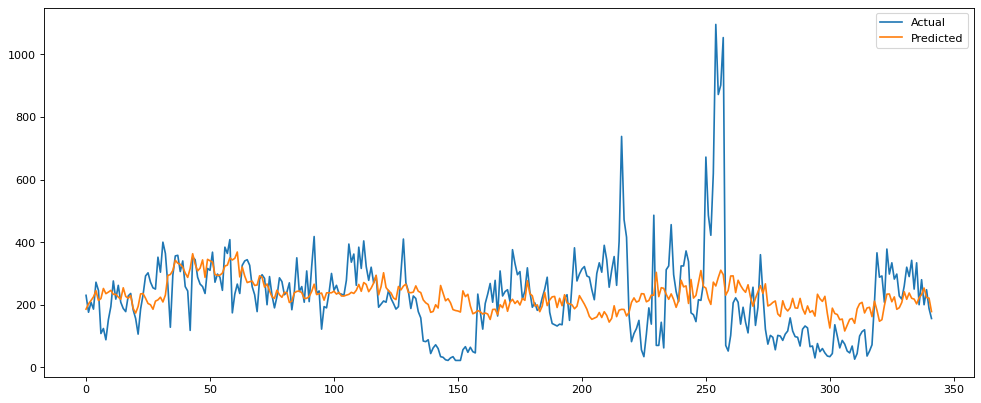

In [96]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
y1_2 = df_temp2['Actual']
y2_2 = df_temp2['Predicted']
plt.plot(y1_2, label = 'Actual')
plt.plot(y2_2, label = 'Predicted')
plt.legend()
plt.show()

In [100]:
mse(y1_2,y2_2)

5916487.419516888

In [101]:
print(f'Mean Square Error: {mse(y1,y2)}')
print(f'Mean Square Error: {mse(y1_1,y2_1)}')
print(f'Mean Square Error: {mse(y1_1,y2_2)}')

Mean Square Error: 4890438.354531564
Mean Square Error: 5290804.508077819
Mean Square Error: 5916487.419516888


Based on MSE, model 1 although less parcimonious has the smaller MSE.

# Communication

- 1) What are the key drivers of sales?

Based on feature importance to sales, variables DailySV, AvgSP, SearCli and DispCli are the key drivers of sales.

- 2) What should the business do to drive incremental sales?

Based on the parameter interpretation of model1, increasing the <font color='blue'> Total paid search clicks delivered Daily</font> and helping to increase the amount of people that click the webpage of HP will have a direct positive impact to sales.

# Time Series Analysis of Sales

Goal: 

- This would helps us to understand more the data with a strong ground.
- Look for outliers modelling, model them and see if the model shows us they influence or not.

In [ ]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pylab as plt
# import warnings
# import statsmodels as sm
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [196]:
import scipy as sp                                             # For BoxCox Checking!
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf   # plot of Autocorrelation function and partial autocorrelation function
from statsmodels.tsa.stattools  import  adfuller               # dickey-Fuller test for unitary root
from statsmodels.graphics.tsaplots import month_plot           # monthplot for seasonality checking
import statsmodels.api as smapi                                # for SARIMA models, ARIMA as well just without the seasonal_order

In [105]:
type(SerieSales)

pandas.core.series.Series

Text(0.5, 0, 'Time')

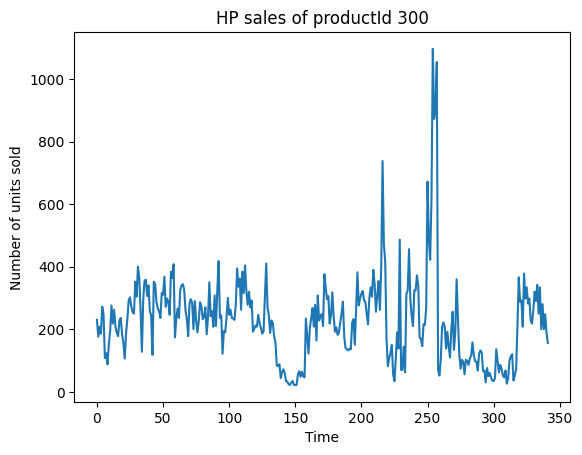

In [107]:
plt.plot(SerieSales)
plt.title("HP sales of productId 300")
plt.ylabel("Number of units sold")
plt.xlabel("Time")

In [ ]:
sp.stats.boxcox(us_gnp,alpha=0.05) #It is necessary to apply the box cox transformation
gdpb=sp.stats.boxcox(us_gnp,lmbda=0.13963606484390664);gdpb=pd.Series(gdpb)
gdplog=np.log(us_gnp)

Since the series present nonstationarity characteristics, we proceed to check for a Box-Cox transformation in case is needed for a systematic account of a general class of variance-stabilizing transformations.

The Box-Cox transformation given by:

$f_{\lambda}(U_t) = \begin{cases} 
      \lambda^{-1} \left(U_t^{\lambda} - 1 \right) & U_t \geq 0, \lambda > 0 \\
      ln\left(U_t \right) & U_t > 0, \lambda = 0
   \end{cases}$

and it is suggested prior to the elimination of trend and/or seasonality from the data. [1]

## Box-Cox Transformation Attempt (Variance stabilization)

We start the analysis by checking if the series need a box cox transformation in order to stabilize the variance.

In [110]:
bc_results = sp.stats.boxcox(SerieSales,alpha=0.05) # It is NOT necessary to apply the box cox transformation

In [111]:
# bc_results[0] # ndarray - Box-Cox power transformed array.
bc_results[1]   # If the lmbda parameter is None, the second returned argument is the lmbda that maximizes the log-likelihood function.

0.4264358901975282

In [112]:
bc_results[2] # confidence intervarl for lambda

(0.3082107987675577, 0.5440614711730702)

In [181]:
ssales_b = sp.stats.boxcox(SerieSales,lmbda=0.4264358901975282)

In [190]:
type(ssales_b)

numpy.ndarray

Text(0.5, 0, 'Time')

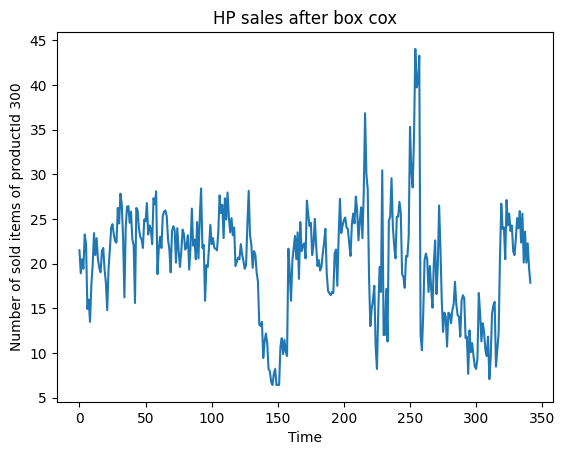

In [182]:
plt.plot(ssales_b)
plt.title("HP sales after box cox")
plt.ylabel("Number of sold items of productId 300") 
plt.xlabel("Time")

The serie after box cox transformation has still tendency.

Next step is check for trend and seasonality.

They are usually detected by inspecting the graph of the (possibly transformed) series. However, they are also characterized by autocorrelation functions that are slowly decaying and nearly periodic, respectively. [1]

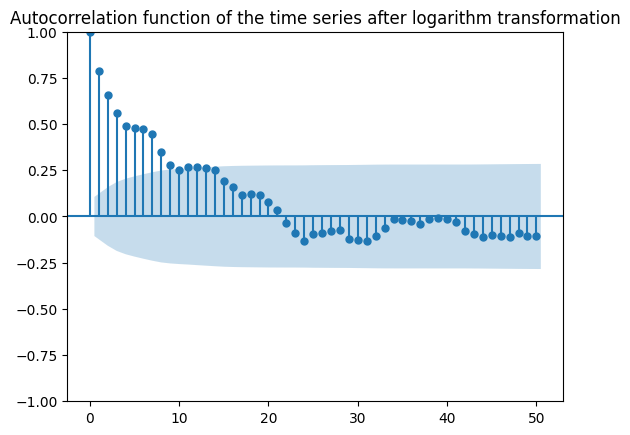

In [183]:
plot_acf(ssales_b, lags=50)
plt.title("Autocorrelation function of the time series after logarithm transformation"); # Función de autocorrelación de la serie diferenciada

From this autocorrelation plot we can see that the function is slowly decaying and nearly periodic as mentioned before, so this is another step to see trend and seasonality in the series.

In order to fit a Sarima model to the time series, first of all we need to identify if the trend is given due to the presence of a $\textbf{unitary root}$, which in that case we will say that the trend is stochastic.

The unitary root test (Dickey-Fuller test) provides us information about the degree in which the null hypothesis will be or not rejected. 

$H_0$: ''There is a root unit in the time series''

vs 

$H_1$: ''There is no root unit in the time series''. 

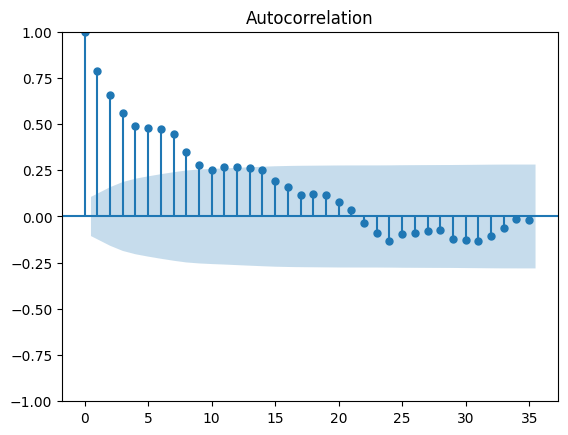

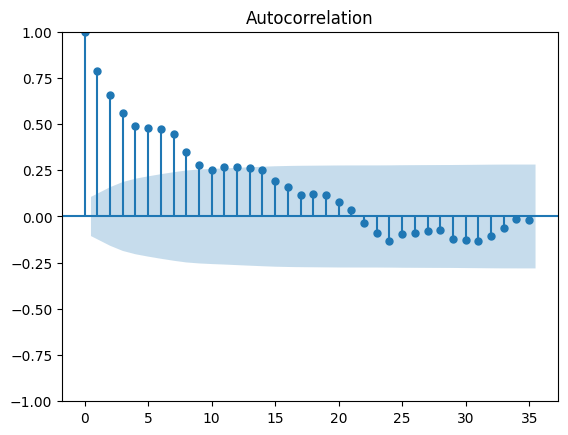

In [185]:
plot_acf(ssales_b, lags=35)

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


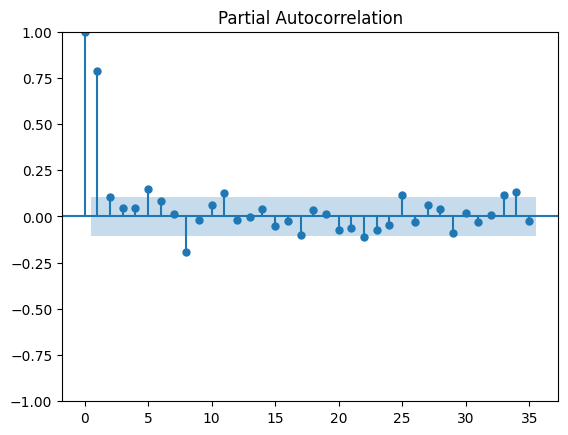

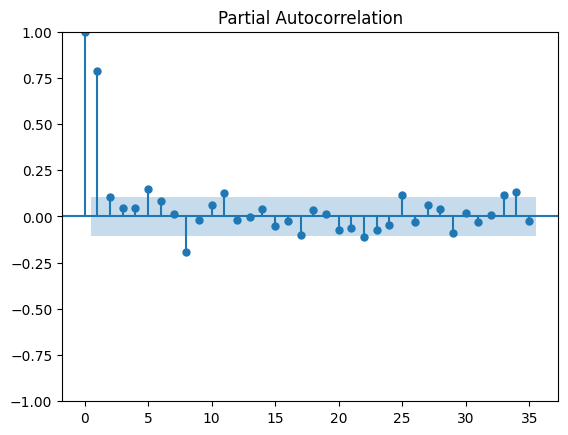

In [186]:
plot_pacf(ssales_b, lags=35)

### The test shows presence of a unitary root in the time series.

Since $p-value \approx 0.026622 > 0.01 = \alpha$ then there is enough statistical evidence to reject $H_0$.

Then an ordinary difference is not done over the time series.

In [187]:
r=adfuller(ssales_b)
print('p-value: %f' % r[1]) #p-value=0.026622>alpha=0.01 - there is a unit root

p-value: 0.026622


In [191]:
# gdpbd=gdpb.diff(periods=1)[1:]
# plt.plot(gdpbd)

dSalesb = pd.Series(ssales_b).diff(periods=1)[1:]

Text(0.5, 0, 'Time')

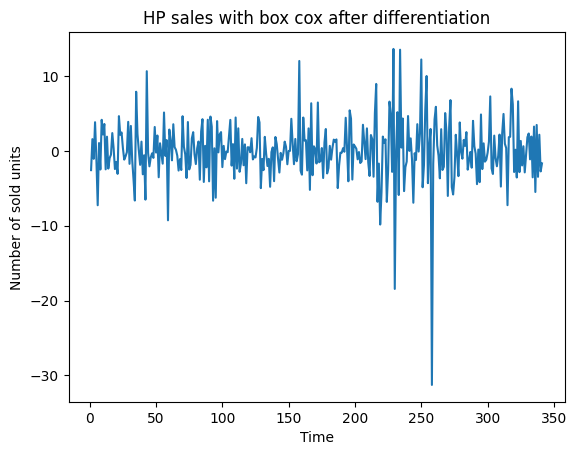

In [192]:
plt.plot(dSalesb)
plt.title("HP sales with box cox after differentiation")
plt.ylabel("Number of sold units") 
plt.xlabel("Time")

Notice, that the time series now has $\underline{\text{no trend}}$.

## $\textbf{ Identification Process }$:

After the series being stationary, it is neccessary to determine the orders p,q to the model.

This is going to be carried out through plot analysis of the autocorrelation functions and partial autocorrelation functions of the stationary series.

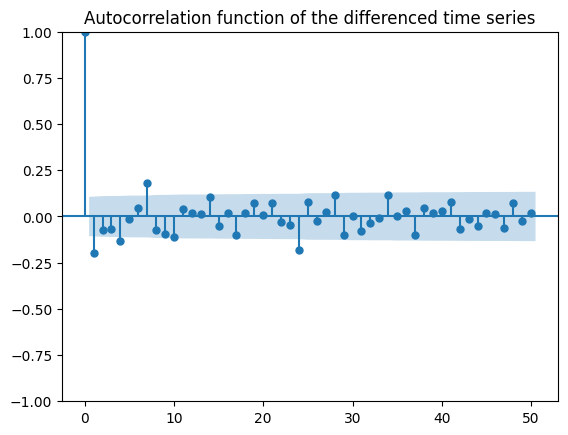

In [193]:
plot_acf(dSalesb, lags=50)
plt.title("Autocorrelation function of the differenced time series"); # Función de autocorrelación de la serie diferenciada

This plot suggest an order q = 7 at most.

$\underline{Recall}$ that the autocorrelation function gets to define the MA process.

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


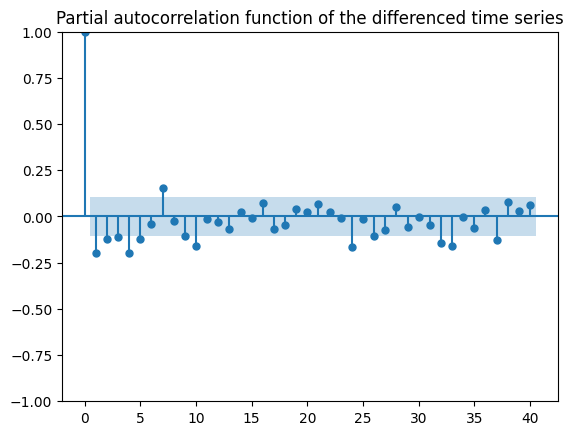

In [194]:
plot_pacf(dSalesb, lags=40)
plt.title("Partial autocorrelation function of the differenced time series"); # Función de autocorrelación parcial de la serie diferenciada

we can see that high lags in the series are significant. This irregular behaviour in the partial autocorrelation plot suggest that it shoul not be fit an autorregressive component (AR) in the model.

$\underline{Recall}$ that the partial autocorrelation function gets to define the AR process.

So far the model would be

$\underline{ARIMA}(p,d,q) = \underline{ARIMA}(0,1,8)$

Now, specification of some models are shown:

In [197]:
m1 = smapi.tsa.statespace.SARIMAX(dSalesb,trend='n', order=(0,1,8)) #LOG #NO
# m1=smapi.tsa.statespace.SARIMAX(gdpb, order=(12,1,5))              #BOX #NO

In [199]:
ajuste1=m1.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47245D+00    |proj g|=  1.27671D+00

At iterate    5    f=  2.81779D+00    |proj g|=  7.48887D-02

At iterate   10    f=  2.76701D+00    |proj g|=  2.50208D-02

At iterate   15    f=  2.74492D+00    |proj g|=  2.34859D-02


 This problem is unconstrained.



At iterate   20    f=  2.74129D+00    |proj g|=  5.28160D-03

At iterate   25    f=  2.74097D+00    |proj g|=  5.48359D-04

At iterate   30    f=  2.74092D+00    |proj g|=  8.27657D-04

At iterate   35    f=  2.74091D+00    |proj g|=  3.96797D-04

At iterate   40    f=  2.74091D+00    |proj g|=  1.51395D-04

At iterate   45    f=  2.74091D+00    |proj g|=  6.82752D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51      1     0     0   6.828D-06   2.741D+00
  F =   2.7409116070159270     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [200]:
print(ajuste1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  341
Model:               SARIMAX(0, 1, 8)   Log Likelihood                -934.651
Date:                Mon, 19 Feb 2024   AIC                           1887.302
Time:                        20:50:14   BIC                           1921.762
Sample:                             0   HQIC                          1901.033
                                - 341                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2545      2.601     -0.482      0.630      -6.353       3.844
ma.L2          0.1787      0.668      0.267      0.789      -1.131       1.489
ma.L3         -0.0062      0.227     -0.027      0.9

All the lags of the weighted average are not significative. Since for example to ma.L1 p-value $= 0.630 > 0.05 = \alpha$, hence there is no significance for the parameter in the model.
We proceed to delete one by one of these paremeters that are not significant until obtain a model with significant components.

In [205]:
ma=[1,0,0,0,0,1,0,0]

mod1=smapi.tsa.statespace.SARIMAX(dSalesb, trend='n', order=(0,1,ma))
mod1fit=mod1.fit()

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41949D+00    |proj g|=  1.17057D+00

At iterate    5    f=  2.87461D+00    |proj g|=  7.66724D-01

At iterate   10    f=  2.79045D+00    |proj g|=  4.61301D-02

At iterate   15    f=  2.78536D+00    |proj g|=  1.19882D-01

At iterate   20    f=  2.76819D+00    |proj g|=  2.57079D-02

At iterate   25    f=  2.76610D+00    |proj g|=  4.88274D-03

At iterate   30    f=  2.76595D+00    |proj g|=  7.30666D-04

At iterate   35    f=  2.76594D+00    |proj g|=  2.63128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [206]:
print(mod1fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                  341
Model:             SARIMAX(0, 1, [1, 6])   Log Likelihood                -943.185
Date:                   Mon, 19 Feb 2024   AIC                           1892.371
Time:                           20:56:06   BIC                           1903.858
Sample:                                0   HQIC                          1896.948
                                   - 341                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1308      0.067    -16.913      0.000      -1.262      -1.000
ma.L6          0.1312      0.032      4.105      0.000       0.069       0.194
sigma2        14.6811      1

We can see that all the components for this model are significant.

### Then, we propose an $Arima(0,1,6)$

This model 'satisfy' all the assumptions of no autocorrelation of the errors given that the Ljung-Box statistic has a $p-value = 0.01 >= 0.01 = \alpha$

$H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).

vs

$H_a$: The data are not independently distributed; they exhibit serial correlation.

So there is not enough evidence to reject $H_0$ that the correlation in the population are 0.

However, this model does not satisfy the assumptions of variance homogeneity and either of normality of the errors. Given that the $p-value = 0.00 < 0.05 = \alpha$, so there is enough evidence to reject $H_0$ that the variance of the errors are homogeneous.

Similarly, by the Jarque-Bera test, with a $p-value = 0.00 < 0.05 = \alpha$ there is enough evidence to reject $H_0$ that the data follows a normal distribution.

In [213]:
ma2=[1,0,0,0,0,1,1,1]

mod2=smapi.tsa.statespace.SARIMAX(dSalesb, trend='n', order=(0,1,ma2))
mod2fit=mod2.fit()

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44882D+00    |proj g|=  1.23027D+00

At iterate    5    f=  2.83400D+00    |proj g|=  5.23955D-02

At iterate   10    f=  2.77569D+00    |proj g|=  2.93914D-02

At iterate   15    f=  2.75822D+00    |proj g|=  4.67474D-02

At iterate   20    f=  2.75453D+00    |proj g|=  5.26154D-03

At iterate   25    f=  2.75427D+00    |proj g|=  2.30342D-04

At iterate   30    f=  2.75425D+00    |proj g|=  2.90311D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [214]:
print(mod2fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  341
Model:             SARIMAX(0, 1, [1, 6, 7, 8])   Log Likelihood                -939.201
Date:                         Mon, 19 Feb 2024   AIC                           1888.402
Time:                                 21:00:58   BIC                           1907.546
Sample:                                      0   HQIC                          1896.030
                                         - 341                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1411      0.069    -16.473      0.000      -1.277      -1.005
ma.L6          0.1740      0.068      2.563      0.010     

These models are not working, it seems that we need to model seasonality with a SARIMA model with the monthplot function. Unfortunately I need the data to be accounted by months and not daily.

# Data by months to analyze the sales with a SARIMA model

In [358]:
df_p300.head(3)

,Date,sales,AvgSP,SearImp,SearCli,DispImp,DispCli,Radio,DailySV,Pages_pv,BounceR
0,2019-08-02,230,26.91,3906,67,10.0,0,0.0,1139441.91,4.50,0.48
1,2019-08-03,176,25.76,3611,46,15.0,0,0.0,1178689.64,4.00,0.51
2,2019-08-04,208,26.23,4700,67,13.0,0,0.0,1217203.92,3.93,0.51


In [359]:
q2 = "SELECT CONCAT(YEAR(Date),'-',MONTH(Date)) AS Date, "\
     "SUM(UnitSales) AS Sales, "\
     "ROUND(AVG(AvgSellingPrice),2) AS AvgSP, "\
     "ROUND(SUM(SearchImpressions),2) AS SearImp, "\
     "ROUND(SUM(SearchClicks),2) AS SearCli, "\
     "ROUND(SUM(DisplayImpressions),2) AS DispImp, "\
     "ROUND(SUM(DisplayClicks),2) AS DispCli, "\
     "ROUND(SUM(RadioSpots),2) AS Radio, "\
     "ROUND(SUM(DailySiteVisits),2) AS DailySV, "\
     "ROUND(SUM(PagesperVisit),2) AS Pages_pv, "\
     "ROUND(AVG(BounceRate),2) AS BounceR "\
     "FROM data_ WHERE ProductId = 300 "\
     "GROUP BY MONTH(Date), YEAR(Date) "\
     "ORDER BY YEAR(Date) ASC, MONTH(Date) ASC;"

In [360]:
p300_m = spark.sql(q2)

In [362]:
p300_m.show(3)

+-------+-----+-----+-------+-------+-----------+-------+-----+-------------+--------+-------+
|   Date|Sales|AvgSP|SearImp|SearCli|    DispImp|DispCli|Radio|      DailySV|Pages_pv|BounceR|
+-------+-----+-----+-------+-------+-----------+-------+-----+-------------+--------+-------+
| 2019-8| 5762|27.23| 122565|   1866|2.8873536E7|  19355|  0.0|3.496682154E7|  123.12|   0.51|
| 2019-9| 8924| 4.57| 158517|   2546| 6.568008E7|  62330|  0.0|3.684134631E7|  129.26|   0.52|
|2019-10| 8104|22.76| 174389|   2730| 4.429337E7|  41551|  0.0|4.144234115E7|  129.34|   0.55|
+-------+-----+-----+-------+-------+-----------+-------+-----+-------------+--------+-------+
only showing top 3 rows



In [368]:
df_p300M = p300_m.toPandas()
df_p300M.head(20)

,Date,Sales,AvgSP,SearImp,SearCli,DispImp,DispCli,Radio,DailySV,Pages_pv,BounceR
0,2019-8,5762,27.23,122565,1866,28873536.0,19355,0.00,34966821.54,123.12,0.51
1,2019-9,8924,4.57,158517,2546,65680080.0,62330,0.00,36841346.31,129.26,0.52
2,2019-10,8104,22.76,174389,2730,44293370.0,41551,0.00,41442341.15,129.34,0.55
3,2019-11,8400,27.03,238538,2697,15272332.0,13917,0.00,39522355.18,130.25,0.53
4,2019-12,4394,31.13,190681,1553,17891441.0,6986,0.00,33508362.05,118.29,0.53
5,2020-1,3454,33.96,200619,1676,53080344.0,30036,0.00,33593069.15,127.77,0.53
6,2020-2,6456,27.09,174852,1430,1668509.0,993,27636.28,34188985.64,129.17,0.53
7,2020-3,8016,26.64,375896,5353,1250403.0,1177,27683.70,34376206.11,136.26,0.52
8,2020-4,11340,35.03,388587,3487,1407101.0,1116,16994.00,41635643.79,119.37,0.53
9,2020-5,3558,34.03,0,0,3558523.0,2312,0.00,32932974.95,102.27,0.53


In [371]:
import seaborn as sns

In [373]:
corr_ = df_p300M.corr()

<AxesSubplot:>

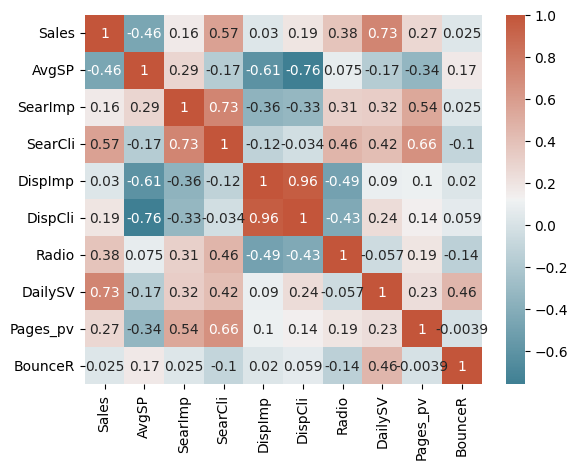

24/02/20 00:09:26 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2226463 ms exceeds timeout 120000 ms
24/02/20 00:09:26 WARN SparkContext: Killing executors is not supported by current scheduler.
24/02/20 00:09:28 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.

24/02/20 00:09:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:09:47 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:15:45 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:16:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:16:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:17:01 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:17:08 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:17:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:17:45 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:17:55 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:18:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:18:32 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:18:51 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:19:12 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:19:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:19:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:19:57 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:20:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:20:37 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:20:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:21:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:21:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:21:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:22:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:22:09 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:22:27 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:22:47 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:22:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:23:15 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:23:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:23:43 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:831)
Caused by: org.apache.spark.rpc.RpcEndpointNotFoundException: Cannot find endpoint: spark://CoarseGrainedScheduler@192.168.0.10:49469
	at org.apache.spark.rpc.netty.NettyRpcEnv.$anonfun$asyncSetupEndpointRefByURI$1(NettyRpcEnv.scala:148)
	at org.apache.spark.rpc.netty.NettyRpcEnv.$anonfun$asyncSetupEndpointRefByURI$1$adapted(NettyRpcEnv.scala:144)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at org.apache.spark.util.ThreadUtils$$anon$1.execute(ThreadUtils.scala:99)
	at scala.concurrent.impl.ExecutionContextImpl$$anon$4.execute(ExecutionContextImpl.scala:138)
	at scala.concurrent.impl.CallbackRunnable.executeWithValue(Promise.scala:72)
	at scala.concurrent.impl.Promise$DefaultPromise

24/02/20 00:24:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:24:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:24:59 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:25:08 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:25:27 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:25:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:25:55 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:26:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:26:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:26:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:27:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:27:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:27:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:27:57 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:28:16 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:28:37 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:28:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:29:03 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:29:22 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:29:32 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:29:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:30:09 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:30:28 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:30:49 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/20 00:30:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:31:15 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:31:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/20 00:31:34 ERROR Executor: Exit as unable to send heartbeats to driver more than 60 times
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 49477)
Traceback (most recent call last):
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pyspark/accumulators.py", line 281, in handle
   

In [374]:
sns.heatmap(corr_, xticklabels = corr_.columns, yticklabels = corr_.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

- Radio and Daily site visits slightly correlate positively with Sales.

- Average Sale Price and Search impressions slightly correlate negatively with Sales.

&ensp;

- Search Click and Search Impressions highly correlate with each other.
- Display Click and Display Impressions highly correlate with each other.
- Pages per visit and Bounce Rate higly correlate negatively with each other.
- Average sale price and Display click higly correlate negatively with each other.

In [364]:
SalesM = pd.Series(df_p300M['Sales'].values,df_p300M['Date'])

In [367]:
len(SalesM)

12

Text(0.5, 0, 'Time')

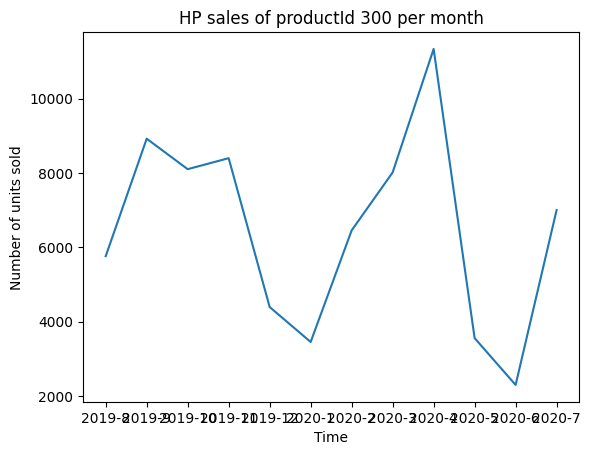

In [365]:
plt.plot(SalesM)
plt.title("HP sales of productId 300 per month")
plt.ylabel("Number of units sold")
plt.xlabel("Time")

we can see from the plot that:
- the time series has an increasing and decreasing trend over the time.
- it seems that it has no period that repeats it could be because the data is dailly. Mayby pltting it monthly could should different insights.

If the data display (plot) characteristics suggesting nonstationarity (e.g., trend and seasonality), then it may be necessary to make a transformation so as to produce a new series that is more compatible with the assumption of $ \textbf{Stationarity}$. Page 164 [1]

$ \textbf{Stationarity}$

$\{X_t\}$ is (weakly) stationary if
- (i) $\mu_X(t)$ is independent of t, and
- (ii) $\gamma_X(t+h,t)$ is independent of t for each h.

Let's continue with more examinations of the dataset

In [376]:
bc_results = sp.stats.boxcox(SalesM,alpha=0.05)
print(f'Lambda parameter: {bc_results[1]} ')
print(f'Confidence interval: {bc_results[2]}')

Lambda parameter: 0.749275364049322 
Confidence interval: (-0.5621609305630628, 2.1456272331952895)


In [377]:
sales_mb = sp.stats.boxcox(SalesM,lmbda=0.749275364049322)

Next step is check for trend and seasonality.

They are usually detected by inspecting the graph of the (possibly transformed) series. However, they are also characterized by autocorrelation functions that are slowly decaying and nearly periodic, respectively. [1]

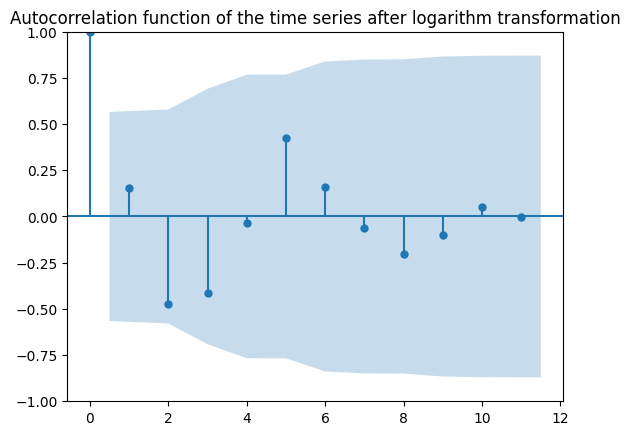

In [379]:
# plot_acf(sales_mb, lags=50)
plot_acf(sales_mb)
plt.title("Autocorrelation function of the time series after logarithm transformation"); # Función de autocorrelación de la serie diferenciada

From this autocorrelation plot we can see that the function is slowly decaying and nearly periodic as mentioned before, so this is another step to see trend and seasonality in the series.

In order to fit a Sarima model to the time series, first of all we need to identify if the trend is given due to the presence of a $\textbf{unitary root}$, which in that case we will say that the trend is stochastic.

The unitary root test (Dickey-Fuller test) provides us information about the degree in which the null hypothesis will be or not rejected. 

$H_0$: ''There is a root unit in the time series''

vs 

$H_1$: ''There is no root unit in the time series''. 

In [381]:
adf = adfuller(sales_mb, autolag='BIC', regression='c', store=False, regresults=False)
adfsalida = pd.Series(adf[0:4], index=['Test Statistic type=nc','p-value','#Lags Used','Number of Observations Used'])
print (adfsalida)

Test Statistic type=nc        -3.204454
p-value                        0.019728
#Lags Used                     3.000000
Number of Observations Used    8.000000
dtype: float64


### The test confirms the presence of a unitary root in the time series.

Since $p-value = 0.019 > 0.01 = \alpha$ then there is enough statistical evidence to reject $H_0$.

Then an ordinary difference is done over the time series and then we proceed to compute the test again to check for an unitary root.

In [383]:
sales_mbd = pd.Series(sales_mb).diff(periods=1)[1:]

In [385]:
adf2 = adfuller(sales_mbd, regression='c', store=False, regresults=False)
adf2salida = pd.Series(adf2[0:4], index=['Test Statistic serie diferenciada','p-value','#Lags Used','Number of Observations Used'])
print (adf2salida)

Test Statistic serie diferenciada   -4.375447
p-value                              0.000328
#Lags Used                           3.000000
Number of Observations Used          7.000000
dtype: float64


Since $p-value = 0.000328 < 0.01 = \alpha$ then there is not enough statistical evidence to reject $H_0$.

hence, it's not neccessary to differentiate again the time series. Therefore for the Sarima model a d = 1 component is chose.

So far we have in the identification process:

$\underline{SARIMA}(p,1,q)$x$(P,D,Q)_s$

Text(0.5, 0, 'Time')

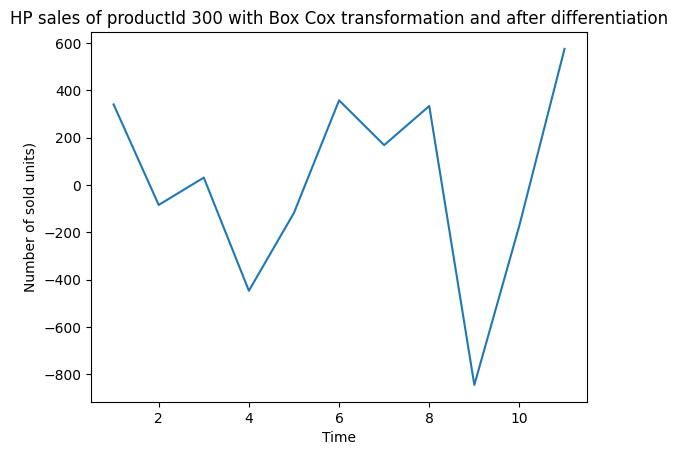

In [387]:
plt.plot(sales_mbd)
plt.title("HP sales of productId 300 with Box Cox transformation and after differentiation")
plt.ylabel("Number of sold units)") 
plt.xlabel("Time")

In [388]:
sales_mbdd = pd.Series(sales_mbd).diff(periods=1)[1:]

Text(0.5, 0, 'Time')

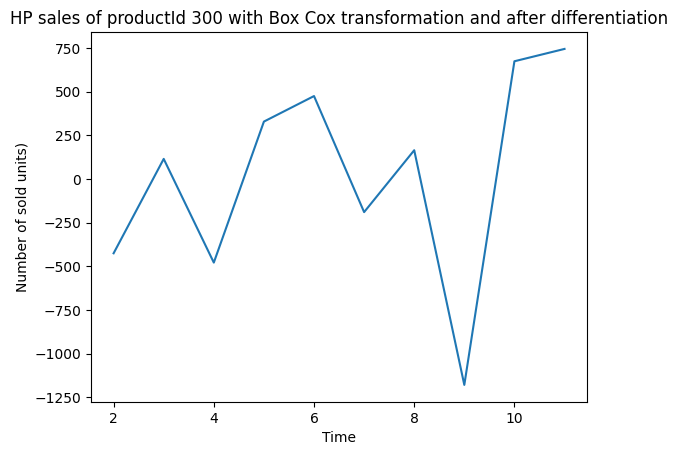

In [389]:
plt.plot(sales_mbdd)
plt.title("HP sales of productId 300 with Box Cox transformation and after differentiation")
plt.ylabel("Number of sold units)") 
plt.xlabel("Time")

# Brief Presentation
https://www.linkedin.com/pulse/lightweight-marketing-mix-modeling-mmm-using-python-jared-randall/